In [141]:
import numpy as np
import TensorFrost as tf
import matplotlib.pyplot as plt

tf.initialize(tf.opengl)

def FFT_axis(X, axis, inverse=False):
    def reverseBits(num, bits):
        reverse_num = tf.reversebits(tf.uint(num)) >> (32 - bits)
        return tf.int(reverse_num) + ((num >> bits) << bits)

    def getIndexPair(i, it):
        k1 = reverseBits(2*i, it+1)
        k2 = k1 + (1 << it)
        return [k1, k2]

    fft_shape = X.shape
    dim = len(fft_shape)
    N = fft_shape[axis]
    it_num = tf.int(tf.floor(tf.log2(tf.float(N))))-1
    
    compute_shape = fft_shape[0:dim - 1]
    compute_shape[axis] = N / 2

    Y = tf.buffer(fft_shape, tf.float32)

    ids = tf.indices(compute_shape)
    i = ids[axis]

    def indices(idx, ch):
        ids2 = list(ids)
        ids2[axis] = idx
        ids2.append(ch)
        return tuple(ids2)
    
    k1, k2 = getIndexPair(i, it_num)
    Re1 = X[indices(k2, 0)]
    Im1 = X[indices(k2, 1)]
    Re2 = X[indices(k1, 0)]
    Im2 = X[indices(k1, 1)]

    k1, k2 = 2*i, 2*i+1
    Y[indices(k1, 0)] = Re2 + Re1
    Y[indices(k1, 1)] = Im2 + Im1
    Y[indices(k2, 0)] = Re2 - Re1
    Y[indices(k2, 1)] = Im2 - Im1

    with tf.loop(1, it_num+1) as it:
        k1, k2 = getIndexPair(i, it)
        Re1 = Y[indices(k2, 0)]
        Im1 = Y[indices(k2, 1)]
        Re2 = Y[indices(k1, 0)]
        Im2 = Y[indices(k1, 1)]
        k3 = (k1 & ((1 << it) - 1)) * (1 << (it_num - it))
        if inverse:
            alpha = 2 * np.pi * tf.float(k3) / tf.float(N)
        else:
            alpha = - 2 * np.pi * tf.float(k3) / tf.float(N)
        C, S = tf.cos(alpha), tf.sin(alpha)
        m = C * Re1 - S * Im1
        n = S * Re1 + C * Im1
        Y[indices(k1, 0)] = Re2 + m
        Y[indices(k1, 1)] = Im2 + n
        Y[indices(k2, 0)] = Re2 - m
        Y[indices(k2, 1)] = Im2 - n

    if inverse:
        Y /= tf.float(N)

    return Y

def FFT_shift(X, axis):
    ids = list(X.indices)
    N = X.shape[axis]
    i = ids[axis]
    ids[axis] = tf.select(i < N/2, i + N/2, i - N/2)
    return X[tuple(ids)]

#in-place FFT implementation
def FFT2():
    Image = tf.input([-1, -1, -1], tf.float32)
    N, M, CH = Image.shape

    Out = tf.buffer([N, M, CH, 2], tf.float32)
    i, j, ch = Image.indices
    Out[i, j, ch, 0] = Image[i, j, ch]
    Out[i, j, ch, 1] = 0

    OutX = FFT_axis(Out, 0)
    OutY = FFT_axis(OutX, 1)

    OutY = FFT_shift(OutY, 0)
    OutY = FFT_shift(OutY, 1)

    i, j, ch, comp = OutY.indices
    k, m = tf.float(i - N/2), tf.float(j - M/2)
    F = tf.sqrt(k**2.0 + m**2.0) #frequency magnitude

    #low-pass filter
    Fc = 3.0 #cutoff frequency
    #H = tf.exp(-F**2.0 / (2 * Fc**2.0)) #gaussian filter
    H = tf.select(F < 1e-5, 1.0, tf.sin(F / Fc) / (F / Fc)) #sinc filter

    OutY = OutY * H

    Res = FFT_shift(OutY, 0)
    Res = FFT_shift(Res, 1)

    Inv = FFT_axis(Res, 0, inverse=True)
    Inv = FFT_axis(Inv, 1, inverse=True)

    return [OutY, Inv]

fft = tf.compile(FFT2)

FFT2:
  Kernel count: 11
  Intermediate buffers: 5
  Host readbacks: 0
  Host writes: 0
  Lines of generated code: 478
  IR Compile time: 38.709099 ms
  Compiler time: 1564.391113 ms



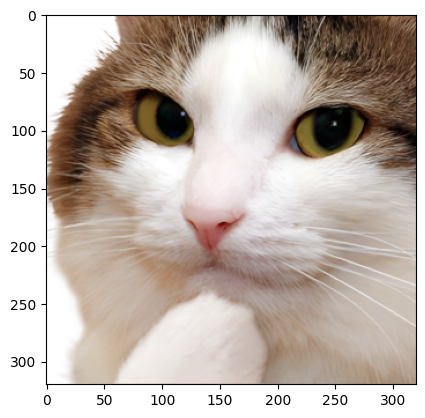

(320, 320, 4)


In [142]:
input_img = np.array(plt.imread("test.png"), dtype=np.float32)
#input_img = input_img[:,:,0:3].reshape(input_img.shape[0], input_img.shape[1], 3)
plt.imshow(input_img)
plt.show()
print(input_img.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


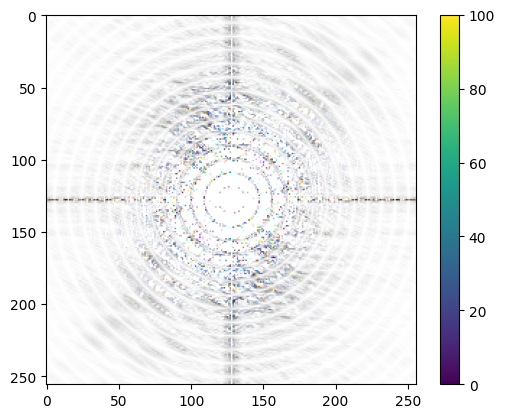

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 4)


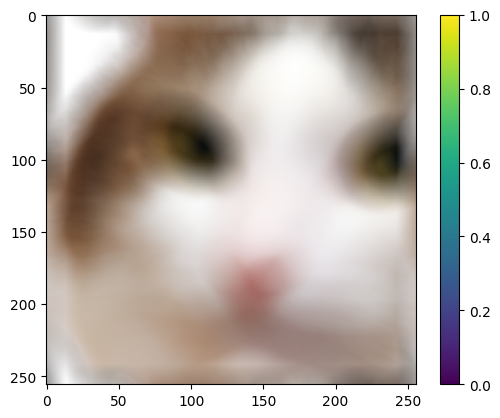

In [143]:
signal = input_img[0:256,0:256,0:4]

signal_tf = tf.tensor(signal)
output, recovered  = fft(signal_tf)
output = output.numpy
recovered = recovered.numpy
output = output[:,:,:,0] + 1j*output[:,:,:,1]
plt.imshow(np.abs(output))
plt.colorbar()
plt.clim(0, 100)
plt.show()
print(output.shape)

recovered = recovered[:,:,:,0] + 1j*recovered[:,:,:,1]
plt.imshow(np.abs(recovered))
plt.colorbar()
plt.clim(0, 1)
plt.show()